## Curve fiting of proteins by dose 

In order to start plotting the curves, we made some modifications to the dose values:  

- we transformed the doses to a logarithmic scale: `dose_log <- log10(dose)`  
- we set the dose spacing to 1: `dose_spacing = 1`  
- we shifted the dose values to ensure all were positive:  
  `dose_shift = abs(min(dose_log)) + dose_spacing`  
- finally, we applied the shift: `dose_log_shifted <- dose_log + dose_shift`  

We then used the **fastbmdR** package on our **norm_signal** data, after filtering out proteins that had 100% missing values.

In [57]:
#
library(ggplot2)

#install.packages("drc", dependencies = TRUE)

devtools::install_github("jessica-ewald/fastbmdR")


Using GitHub PAT from the git credential store.

Skipping install of 'fastbmdR' from a github remote, the SHA1 (b3681861) has not changed since last install.
  Use `force = TRUE` to force installation



In [58]:
library(fastbmdR)
library(dplyr)
library(knitr)

In [ ]:
## computing the BMD for the proteiomic data

#df <- read.csv("../00.exploratory_analysis/outputs/df_CC_Proba.csv", sep = ",")

df <- read.csv("../00.exploratory_analysis/outputs/norm_signal_filtered.csv", sep= ',')

df <- df[df$Metadata_Categories != "JUMP Control", ]
df <- df[df$Metadata_Compound != "UNTREATED", ]

models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1  

unique_compounds <- unique(df$Metadata_Compound)

feat_cols = colnames(df)[!grepl("Metadata", colnames(df))]
res = list()
gene_table <- list()

all_bmd_pass <- data.frame()

for (compound in unique_compounds) {
  
  compound_data <- df[df$Metadata_Compound %in% c(compound, "DMSO"), ]
  
  dose <- compound_data$Metadata_Concentration
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose = unique(dose) %>% sort(. , decreasing = TRUE)
  dose_spacing = abs(log10(rank_dose[2]/rank_dose[1]))
  
  dose_shift = abs(min(dose_log)) + dose_spacing
  dose_shifted = dose_log
  dose_shifted[dose_shifted != 0] = dose_shifted[dose_shifted != 0] + dose_shift
  
  if (length(unique(compound_data$Metadata_Concentration)) > 2) {  
    
    print(paste("Processing compound:", compound))  
    dose <- dose_shifted
    
    compound_mat <- t(compound_data[, feat_cols])  
    min_val = abs(min(compound_mat, na.rm=TRUE))  
    add_min = min_val + 0.1 * min_val  
    mat_new = compound_mat + add_min  
    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        fit_obj <- PerformBMDCalc(fit_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        
        bmd_res <- fit_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        fit_obj$bmd_pass <- bmd_pass

        res[[compound]] = fit_obj
        
        if (nrow(bmd_pass) > 0) {
          bmd_pass$compound_name <- compound
          all_bmd_pass <- rbind(all_bmd_pass, bmd_pass) 
        }
      }, error = function(e) {
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }  
}




In [ ]:
#write.csv(all_bmd_pass, "/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response/outputs/bmd_pass_protein.csv", row.names = FALSE)


In [71]:
## calculating the bmd values at real concentration

all_bmd_pass$Concentration <- NA
all_bmd_pass$Concentration_L <- NA
all_bmd_pass$Concentration_U <- NA

for (i in 1:nrow(all_bmd_pass)) {
  compound <- all_bmd_pass$compound_name[i]
  bmd <- all_bmd_pass$bmd[i]
  bmdl <- all_bmd_pass$bmdl[i]
  bmdu <- all_bmd_pass$bmdu[i]
  
  compound_data <- df[df$Metadata_Compound == compound, ]
  dose <- compound_data$Metadata_Concentration
  
  # Transformer en log10 (en évitant les zéros)
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose <- unique(dose)
  rank_dose <- sort(rank_dose, decreasing = TRUE)
  
  # Saut entre deux concentrations successives (log-échelle)
  if (length(rank_dose) > 1) {
    dose_spacing <- abs(log10(rank_dose[2] / rank_dose[1]))
  } else {
    dose_spacing <- 1  # Valeur arbitraire s'il n'y a qu'une concentration
  }
  
  dose_shift <- abs(min(dose_log, na.rm = TRUE)) + dose_spacing
  
  all_bmd_pass$Concentration[i] <- 10^(bmd - dose_shift)
  all_bmd_pass$Concentration_L[i] <- 10^(bmdl - dose_shift)
  all_bmd_pass$Concentration_U[i] <- 10^(bmdu - dose_shift)
}



In [ ]:
# Count the frequency of each protein

library(dplyr)

compound_count_per_protein <- all_bmd_pass %>%
  group_by(gene.id) %>%
  summarise(n_compounds = n_distinct(compound_name)) %>%
  arrange(desc(n_compounds))


print(compound_count_per_protein)



# A tibble: 168 x 2
   gene.id n_compounds
   <chr>         <int>
 1 Q14393           16
 2 P09341           14
 3 Q9H2A7           14
 4 P0DJI8           13
 5 Q12805           13
 6 Q15113           13
 7 Q16610           13
 8 Q9BY76           13
 9 P09237           12
10 P13500           12
# i 158 more rows


In [85]:
list_plot <- list()  

for (i in 1:nrow(all_bmd_pass)) {  
  tryCatch({
    gene_id <- all_bmd_pass$gene.id[i]
    compound <- all_bmd_pass$compound_name[i]
    
    temp <- plot_bmd_curve(gene_id, res[[compound]], return_type = "plot.data")
    
    temp$protein <- gene_id
    temp$compound <- compound
    temp$category <- all_bmd_pass$Metadata_Categories[i]
    temp$bmd <- all_bmd_pass$bmd[i]
    temp$bmd_l <- all_bmd_pass$bmdl[i]
    temp$bmd_u <- all_bmd_pass$bmdu[i]
    temp$Concentration <- all_bmd_pass$Concentration[i]
    
    list_plot[[i]] <- temp
  }, error = function(e) {
    message(sprintf("Error for gene_id %s and compound %s : %s", gene_id, compound, e$message))
  })
}

final_df <- do.call(rbind, list_plot)

# Aperçu des résultats
kable(head(final_df))



|  x| Observations|       f_x|protein |compound      |      bmd|    bmd_l|   bmd_u| Concentration|
|--:|------------:|---------:|:-------|:-------------|--------:|--------:|-------:|-------------:|
|  0|    0.1879041| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1960699| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.2082702| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1722449| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1719874| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1936951| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|

In [86]:
print(head(final_df))

  x Observations       f_x protein      compound      bmd    bmd_l    bmd_u
1 0    0.1879041 0.1882725  O00175 Actinomycin D 4.345116 4.243573 4.437511
2 0    0.1960699 0.1882725  O00175 Actinomycin D 4.345116 4.243573 4.437511
3 0    0.2082702 0.1882725  O00175 Actinomycin D 4.345116 4.243573 4.437511
4 0    0.1722449 0.1882725  O00175 Actinomycin D 4.345116 4.243573 4.437511
5 0    0.1719874 0.1882725  O00175 Actinomycin D 4.345116 4.243573 4.437511
6 0    0.1936951 0.1882725  O00175 Actinomycin D 4.345116 4.243573 4.437511
  Concentration
1      110.6843
2      110.6843
3      110.6843
4      110.6843
5      110.6843
6      110.6843


In [ ]:
## we now plot the bmd curves for each compound and protein and save them in a pdf file

library(ggplot2)
library(ggforce)


n_per_page <- 9  


final_df$compound_protein <- paste(final_df$compound, final_df$protein, sep = " - ")


plot_groups <- unique(final_df$compound_protein)
n_pages <- ceiling(length(plot_groups) / n_per_page)


pdf_file <- "./outputs/bmd_curves.pdf"
pdf(pdf_file, width = 15, height = 10)

for (i in 1:n_pages) {
  tryCatch({
    p <- ggplot(final_df, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +

      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      
      labs(title = sprintf("BMD curves", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}
dev.off()


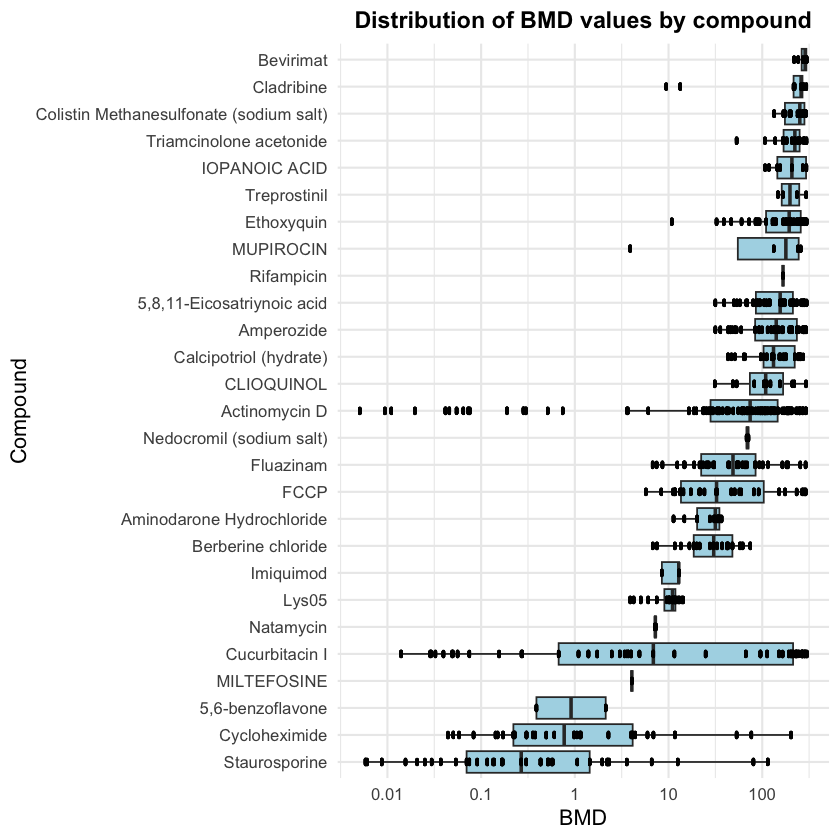

In [88]:
# boxplot of the BMD value per compound

library(ggplot2)

df_bmd <- final_df[!is.na(final_df$Concentration), ]


compound_order <- df_bmd %>%
  group_by(compound) %>%
  summarise(median_bmd = median(Concentration, na.rm = TRUE)) %>%
  arrange(median_bmd) %>%
  pull(compound)


df_bmd$compound <- factor(df_bmd$compound, levels = compound_order)


ggplot(df_bmd, aes(x = log10(Concentration), y = compound)) +
  geom_boxplot(fill = "lightblue", outlier.shape = NA, width = 0.8) +
  geom_jitter(width = 0, height = 0.1, alpha = 0.3, color = "black", size = 0.3) +
  labs(
    title = "Distribution of BMD values by compound",
    x = "BMD",
    y = "Compound"
  ) +
  scale_x_continuous(
    breaks = log10(c(0.001, 0.01, 0.1, 1, 10, 100)),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.text.y = element_text(size = 10),
    axis.text.x = element_text(size = 10),
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold")
  )




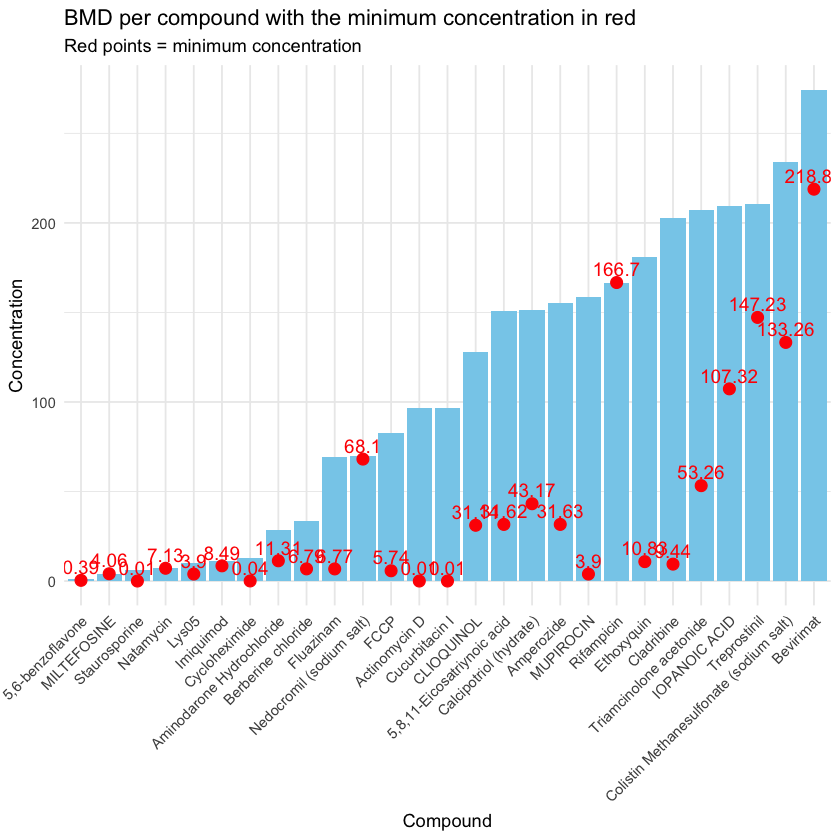

In [ ]:
## Calculate the mean concentration for each compound

compound_categories <- df %>%
  select(Metadata_Compound, Metadata_Categories) %>%
  distinct() %>%
  rename(compound = Metadata_Compound, category_df = Metadata_Categories)

compound_summary <- final_df %>%
  group_by(compound) %>%
  summarise(
    mean_concentration = mean(Concentration, na.rm = TRUE),  
    min_concentration = min(Concentration, na.rm = TRUE),   
    nb_proteins = n_distinct(protein)
  ) %>%
  left_join(compound_categories, by = "compound")


p <- ggplot(compound_summary, aes(x = reorder(compound, mean_concentration), y = mean_concentration)) +
  geom_col(fill = "skyblue") + 
  geom_point(aes(y = min_concentration), color = "red", size = 3) +  
  geom_text(aes(y = min_concentration, label = round(min_concentration, 2)), 
            color = "red", vjust = -0.5, size = 4) + 
  #geom_text(aes(label = nb_proteins, y = mean_concentration + 5), size = 5, vjust = 0) +
  labs(title = "BMD per compound with the minimum concentration in red",
       x = "Compound",
       y = "Concentration",
       subtitle = "Red points = minimum concentration") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

print(p)


# A tibble: 27 x 3
   compound                                pod_10th_percentile nb_proteins
   <chr>                                                 <dbl>       <int>
 1 Staurosporine                                        0.0156          37
 2 Cucurbitacin I                                       0.0396          49
 3 Cycloheximide                                        0.0805          30
 4 Actinomycin D                                        0.189          112
 5 5,6-benzoflavone                                     0.389            2
 6 MUPIROCIN                                            3.90             4
 7 MILTEFOSINE                                          4.06             1
 8 Lys05                                                4.98            20
 9 Natamycin                                            7.13             2
10 Imiquimod                                            8.49             3
11 Cladribine                                           9.44             9
12 FCC

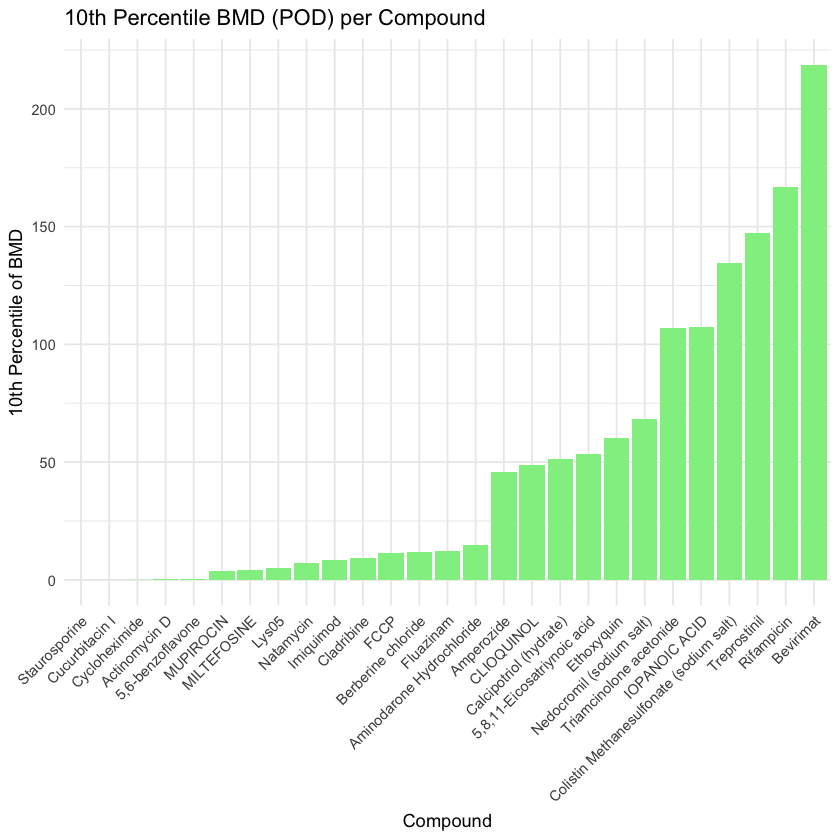

In [100]:
### Calculate the 10th percentile of BMD for each compound across all protein bmds 

pod_summary <- final_df %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein)
  ) %>%
  arrange(pod_10th_percentile)

print(pod_summary, n=Inf)

ggplot(pod_summary, aes(x = reorder(compound, pod_10th_percentile), y = pod_10th_percentile)) +
  geom_col(fill = "lightgreen") +
  labs(title = "10th Percentile BMD (POD) per Compound",
       x = "Compound",
       y = "10th Percentile of BMD") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



In [ ]:
#write.csv(compound_summary, "/Users/grigoryanmariam/Downloads/proteomic_bmd_dose_results.csv", row.names = FALSE)


## Cell Count From CP data

In [34]:
library(arrow)
library(dplyr)

raw_data <- read_parquet("../00.exploratory_analysis/CP_data/raw.parquet")

#raw_data <- raw_data %>% 
#  filter(Metadata_BROAD_ID != "EMPTY")


raw_data <- raw_data %>%
  mutate(
    `Metadata_Compound Name` = ifelse(Metadata_BROAD_ID == "DMSO", "DMSO", `Metadata_Compound Name`),
    Metadata_Annotation = ifelse(Metadata_BROAD_ID == "DMSO", "DMSO", Metadata_Annotation),
    `Metadata_Compound Name` = ifelse(Metadata_BROAD_ID == "EMPTY", "EMPTY", `Metadata_Compound Name`),
    Metadata_Annotation = ifelse(Metadata_BROAD_ID == "EMPTY", "no treatment", Metadata_Annotation)
  )

selected_data <- raw_data %>%
  select('Metadata_Well', 'Metadata_Count_Cells', 'Metadata_plate_map_name')


In [35]:
df <- read.csv("../00.exploratory_analysis/outputs/norm_signal_filtered.csv", sep= ',')

df_pred <- read.csv("./outputs/df_pred.csv", sep= ',')


We add the count cell columns from CP data to the proteomic data according to the plate number and compound well. 

In [37]:
library(dplyr)

df <- df %>%
  mutate(Metadata_plate_map_name = case_when(
    Metadata_Plate == "BR00145683" ~ "BR00145695",
    Metadata_Plate == "BR00145686" ~ "BR00145692",
    TRUE ~ Metadata_Plate 
  ))



In [38]:
df <- df %>%
  left_join(selected_data, 
            by = c("Metadata_Well" = "Metadata_Well", 
                   "Metadata_plate_map_name" = "Metadata_plate_map_name"))


df <- merge(df, df_pred[, c("Metadata_Well", "Metadata_plate_map_name", "Probability")], 
            by = c("Metadata_Well", "Metadata_plate_map_name"),
            all.x = TRUE)


In [39]:
# I replace the missing values probability with 0 from Jump controls and DMSO

df$Probability[is.na(df$Probability)] <- 0

sum(is.na(df$Probability))


[1] 0

In [ ]:
#write.csv(df, file = "./outputs/df_CC_Proba.csv", row.names = FALSE)

#/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/outputs/bmd_curves.pdf

In [ ]:
# we keep only the columns of interest

df_cc <- df[, c("Metadata_Compound", 'Probability', "Metadata_Concentration", "Metadata_Count_Cells")]


#df_cc <- df_cc[df_cc$Metadata_Compound != "UNTREATED", ]


df_cc <- df_cc %>%
  rename(
    CC0 = Metadata_Count_Cells,
    RF_prob= Probability
  )


print(head(df_cc))


  Metadata_Compound RF_prob Metadata_Concentration  CC0
1         LY2109761    0.00                  5.100 1570
2         UNTREATED    0.00                  0.000 3206
3        Cladribine    0.50                  1.235 3059
4     Actinomycin D    0.61                300.000 1914
5      Treprostinil    0.55                  3.704 3355
6         Bevirimat    0.61                  3.704 4112


In [ ]:
models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1  

unique_compounds <- unique(df_cc$Metadata_Compound)

feat_cols = colnames(df_cc)[!grepl("Metadata", colnames(df_cc))]
res = list()
gene_table <- list()

all_bmd_pass <- data.frame()

for (compound in unique_compounds) {
  
  compound_data <- df_cc[df_cc$Metadata_Compound %in% c(compound, "DMSO"), ]
  
  dose <- compound_data$Metadata_Concentration
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose = unique(dose) %>% sort(. , decreasing = TRUE)
  dose_spacing = abs(log10(rank_dose[2]/rank_dose[1]))
  
  dose_shift = abs(min(dose_log)) + dose_spacing
  dose_shifted = dose_log
  dose_shifted[dose_shifted != 0] = dose_shifted[dose_shifted != 0] + dose_shift
  
  if (length(unique(compound_data$Metadata_Concentration)) > 2) {  
    
    print(paste("Processing compound:", compound))  
    dose <- dose_shifted
    
    compound_mat <- t(compound_data[, feat_cols])  
    min_val = abs(min(compound_mat, na.rm=TRUE))  
    add_min = min_val + 0.1 * min_val  
    mat_new = compound_mat + add_min  
    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        fit_obj <- PerformBMDCalc(fit_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        
        bmd_res <- fit_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        fit_obj$bmd_pass <- bmd_pass

        res[[compound]] = fit_obj
        
        if (nrow(bmd_pass) > 0) {
          bmd_pass$compound_name <- compound
          all_bmd_pass <- rbind(all_bmd_pass, bmd_pass)  # Ajout des résultats
        }
      }, error = function(e) {
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }  
}


In [49]:

list_plot <- list()

for (i in 1:nrow(all_bmd_pass)) {
  tryCatch({
    gene_id <- all_bmd_pass$gene.id[i]
    compound <- all_bmd_pass$compound_name[i]

    temp <- plot_bmd_curve(gene_id, res[[compound]], return_type = "plot.data")

    temp$protein   <- gene_id
    temp$compound  <- compound
    #temp$category  <-
    temp$bmd       <- all_bmd_pass$bmd[i]
    temp$bmd_l     <- all_bmd_pass$bmdl[i]
    temp$bmd_u     <- all_bmd_pass$bmdu[i]
    
    list_plot[[i]] <- temp
  }, error = function(e) {
    message(sprintf("Erreur pour gene_id %s et compound %s : %s", gene_id, compound, e$message))
  })
}

final_df <- do.call(rbind, list_plot)
kable(final_df)

Erreur pour gene_id CC0 et compound 5,8,11-Eicosatriynoic acid : les arguments impliquent des nombres de lignes diff'erents : 100, 0





|         x| Observations|          f_x|protein |compound                                |       bmd|     bmd_l|     bmd_u|
|---------:|------------:|------------:|:-------|:---------------------------------------|---------:|---------:|---------:|
| 0.0000000|         0.57|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|
| 0.0000000|         0.00|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|
| 0.0000000|         0.84|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|
| 0.0000000|         0.00|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|
| 0.0000000|         0.27|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|
| 0.0000000|         0.39|    0.0790662|RF_prob |Cladribine                              | 1.1030340| 0.9593434| 1.2553146|
| 0.00

In [50]:
## calculating the bmd values at real concentration

final_df$Concentration <- NA
final_df$Concentration_L <- NA
final_df$Concentration_U <- NA

for (i in 1:nrow(final_df)) {
  compound <- final_df$compound[i]
  bmd <- final_df$bmd[i]
  bmdl <- final_df$bmd_l[i]
  bmdu <- final_df$bmd_u[i]

  compound_data <- df[df$Metadata_Compound == compound, ]
  dose <- compound_data$Metadata_Concentration

  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])

  rank_dose <- unique(dose) %>% sort(decreasing = TRUE)
  dose_spacing <- abs(log10(rank_dose[2] / rank_dose[1]))
  
  dose_shift <- abs(min(dose_log)) + dose_spacing

  final_df$Concentration[i] <- 10^(bmd - dose_shift)
  final_df$Concentration_L[i] <- 10^(bmdl - dose_shift)
  final_df$Concentration_U[i] <- 10^(bmdu - dose_shift)
}

In [52]:
## we now plot the bmd curves for each compound and protein and save them in a pdf file


library(ggplot2)
library(ggforce)

# Filtrer les données pour le type de protéine "CC0"
final_df_CC0 <- final_df[final_df$protein == "CC0", ]

n_per_page <- 9  

final_df_CC0$compound_protein <- paste(final_df_CC0$compound, final_df_CC0$protein, sep = " - ")

plot_groups_CC0 <- unique(final_df_CC0$compound_protein)
n_pages_CC0 <- ceiling(length(plot_groups_CC0) / n_per_page)

pdf_file_CC0 <- "./outputs/cc0_bmd_curves.pdf"
pdf(pdf_file_CC0, width = 15, height = 10)

for (i in 1:n_pages_CC0) {
  tryCatch({
    p <- ggplot(final_df_CC0, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +
      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      labs(title = sprintf("BMD curves - CC0 - Page %d", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}

dev.off()


Warning message:
"Removed 196 rows containing missing values or values outside the scale range
(`geom_point()`)."


pdf 
  2

In [55]:
# curves of probability of Random Forest classification 

final_df_RF_prob <- final_df[final_df$protein == "RF_prob", ]

n_per_page <- 9  

final_df_RF_prob$compound_protein <- paste(final_df_RF_prob$compound, final_df_RF_prob$protein, sep = " - ")

plot_groups_RF_prob <- unique(final_df_RF_prob$compound_protein)
n_pages_RF_prob <- ceiling(length(plot_groups_RF_prob) / n_per_page)

pdf_file_RF_prob <- "./outputs/RF_prob_bmd_curves.pdf"
pdf(pdf_file_RF_prob, width = 15, height = 10)

for (i in 1:n_pages_RF_prob) {
  tryCatch({
    p <- ggplot(final_df_RF_prob, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +
      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      labs(title = sprintf("BMD curves - RF_prob - Page %d", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}

dev.off()


Warning message:
"Removed 882 rows containing missing values or values outside the scale range
(`geom_point()`)."


pdf 
  2

In [ ]:
## Calculate the mean concentration for each compound


compound_summary <- final_df %>%
  group_by(compound, protein) %>%
  summarise(
    mean_concentration = mean(Concentration, na.rm = TRUE),
    .groups = "drop"
  )

print(compound_summary)


# A tibble: 11 x 3
   compound                                protein mean_concentration
   <chr>                                   <chr>                <dbl>
 1 5,6-benzoflavone                        RF_prob            0.0512 
 2 Actinomycin D                           RF_prob            0.0790 
 3 Berberine chloride                      RF_prob            0.00932
 4 Cladribine                              RF_prob            0.0634 
 5 Colistin Methanesulfonate (sodium salt) RF_prob            0.0499 
 6 Cucurbitacin I                          RF_prob            0.0613 
 7 Ethoxyquin                              CC0              258.     
 8 FCCP                                    CC0              240.     
 9 MUPIROCIN                               RF_prob            0.0687 
10 Natamycin                               RF_prob            0.00513
11 Staurosporine                           RF_prob            0.118  
